# **EPS Meteograms with Herbie**
<a href="https://githubtocolab.com/csteele2/Wx4Colab/blob/master/EPS_Meteograms_with_Herbie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a> <br/>
This notebook uses [Herbie](https://blaylockbk.github.io/Herbie/_build/html/index.html) to download EPS [ECMWF OpenData](https://www.ecmwf.int/en/forecasts/datasets/open-data) (0.4 degree data), the [Synoptic Data metadata API](https://developers.synopticdata.com/mesonet/v2/stations/metadata/) to locate a station, and make ensemble meteorgrams- similar to that on WeatherBell or WeatherModels. Note this is really meant for archive data (there are better ways/places for real-time data), the data is pretty tempermental, and even one messed up timestep (which seems to be common) will pretty much ruin your whole effort.
If you get the following error, that is exactly what has happened:
> ValueError: Cannot assign to the .data attribute of dimension coordinate a.k.a IndexVariable 'number'. Please use DataArray.assign_coords, Dataset.assign_coords or Dataset.assign as appropriate.

There is pretty much nothing you can do to recover from that, other than try again later, or try a different run.

*Caleb Steele, https://github.com/csteele2/Wx4Colab

##**1 - Install CondaColab**
This will manage the installation of the packages we need, like [Herbie](https://blaylockbk.github.io/Herbie/_build/html/index.html). <br />**NOTE**: this will restart the notebook, and you will get a crash popup in the lower-left corner that you can safely ignore

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:13
🔁 Restarting kernel...


##**2 - Install and Import Packages**
This will take about a minute to run.

In [ ]:
!mamba install -q -c conda-forge herbie-data cfgrib matplotlib seaborn xarray cartopy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects # to add outline to text, etc.
from cartopy import crs as ccrs, feature as cfeature
from herbie import Herbie
import seaborn as sns
from datetime import datetime, timedelta
import xarray as xr
import numpy as np
import pandas as pd
import requests
import json


                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (1.0.0) supported by @QuantStack

        GitHub:  https://github.com/mamba-org/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████



##**3 - Download Data**
This will download global ensemble data, trim it to north america, then store it in an xarray object. It will process a large amount of data, so **it will take 20-30+ minutes to run**.

In [ ]:
#@title Download Data | Options { display-mode: "form" }
model_initialization = "2022-12-07" #@param {type:"date"}
model_cycle = 0 #@param {type:"integer"}
model_run = datetime.strptime(model_initialization,'%Y-%m-%d') + timedelta(hours = model_cycle)
model_variable = "precipitation" #@param ["precipitation", "2m temperature"]
if model_variable == "precipitation":
  variable = "tp"
elif model_variable == "2m temperature":
  variable = "2t"

#@markdown ----------------------------------------------------------

#@markdown <b>Select forecast hour start, end, and interval hours.</b><br />
#@markdown &nbsp; &nbsp; &nbsp; &nbsp; --> For times 00z &12z: 0 to 144 by 3, 150 to 360 by 6.<br />
#@markdown  &nbsp; &nbsp; &nbsp; &nbsp; --> For times 06z & 18z: 0 to 144 by 3.

forecast_hour_start = 3 #@param {type:"integer"}
forecast_hour_end = 144 #@param {type:"integer"}
forecast_hour_interval = 3 #@param {type:"integer"}


###########################################################################
eps_all = []
valid_times = []
#forecast_hours = range(forecast_hour_start,75,forecast_hour_interval)
forecast_hours = range(forecast_hour_start, forecast_hour_end + forecast_hour_interval, forecast_hour_interval)
model_search_string = ":"+variable+":"
#ptotal = fast_Herbie_xarray(DATES=[model_run.strftime('%Y-%m-%d %H:00')], model="ecmwf", product="enfo", fxx=forecast_hours, max_threads=5, search_string=model_search_string)

for t in forecast_hours:
    H = Herbie(model_run.strftime('%Y-%m-%d %H:00'), model="ecmwf", product="enfo", fxx=t, priority=['azure'], save_dir="/content/data")
    with H.xarray(":"+variable+":")[0] as eps:
        #tp = tp.rename({"number":"pertubation"})
        eps_all.append(eps.sel(longitude=slice(-180,-30), latitude=slice(85,5)))
        valid_times.append(model_run + timedelta(hours=t))

ecmwfe = xr.concat([eps_all[i] for i in range(0,len(forecast_hours))], dim='step')



✅ Found ┊ model=ecmwf ┊ product=enfo ┊ 2022-Dec-07 00:00 UTC F03 ┊ GRIB2 @ azure ┊ IDX @ azure
Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=ecmwf ┊ product=enfo ┊ 2022-Dec-07 00:00 UTC F06 ┊ GRIB2 @ azure ┊ IDX @ azure
Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=ecmwf ┊ product=enfo ┊ 2022-Dec-07 00:00 UTC F09 ┊ GRIB2 @ azure ┊ IDX @ azure
Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=ecmwf ┊ product=enfo ┊ 2022-Dec-07 00:00 UTC F12 ┊ GRIB2 @ azure ┊ IDX @ azure
Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=ecmwf ┊ product=enfo ┊ 2022-Dec-07 00:00 UTC F15 ┊ GRIB2 @ azure ┊ IDX @ azure
Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=ecmwf ┊ product=enfo ┊ 2022-Dec-07 00:0

##**4 - Make Plots**
This will extract values for you chosen station/point, and, if you selected a bucket precipitation, derive it from the total precipitation that is downloaded. The plot will display below and also save to a png if you click on the folder icon on the left bar.

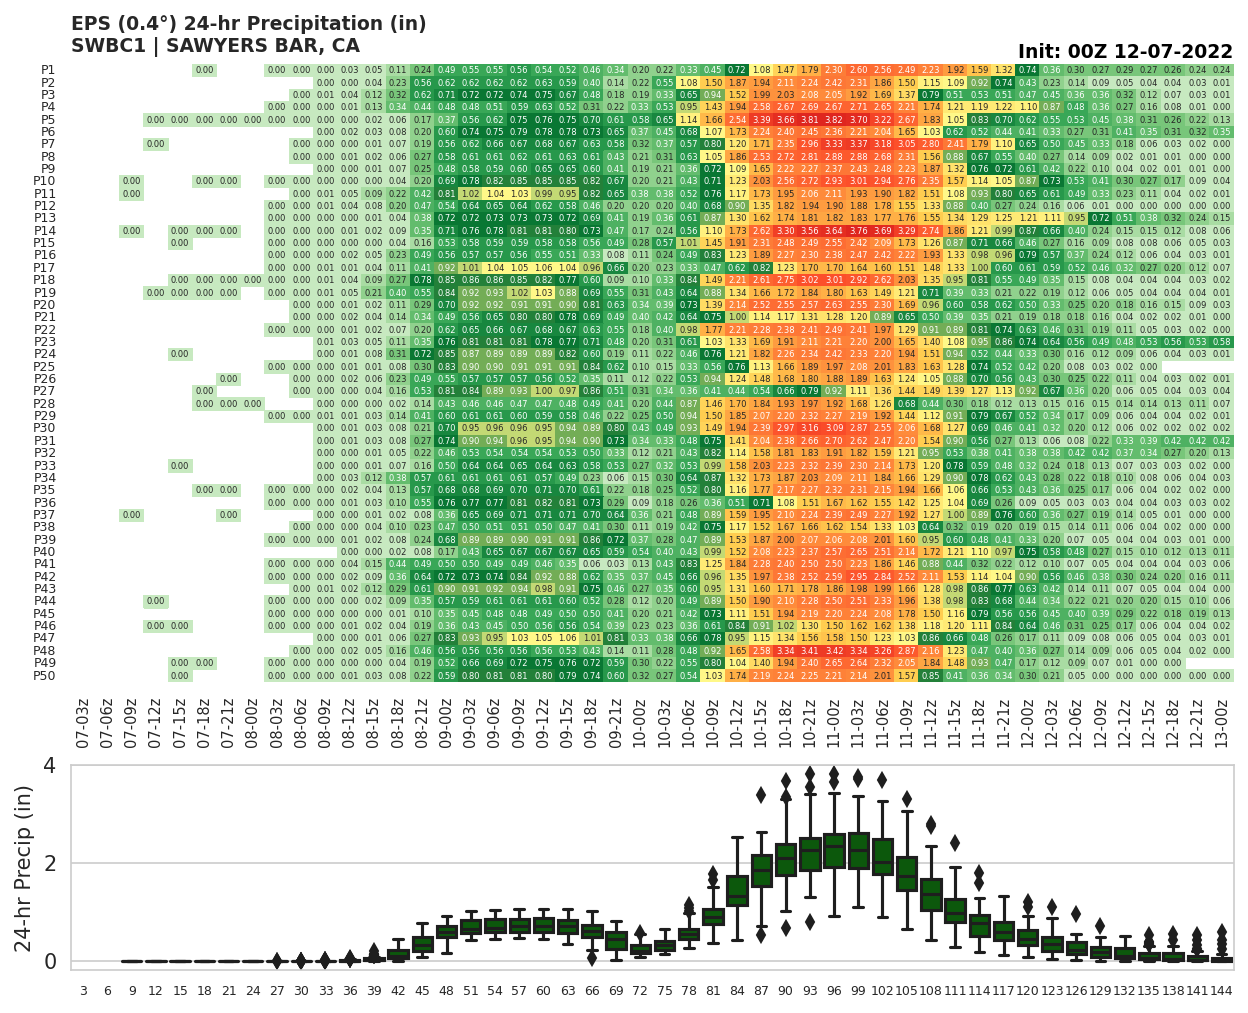

In [ ]:
#@title Make Plot | Options { display-mode: "form" }
site_id = "SWBC1" #@param {type:"string"}
synoptic_token = ""#@param {type:"string"}
#@markdown If you downloaded precipitation, choose what precipitation you want
precipitation_selection = "24-hr" #@param ["Total", "24-hr", "48-hr", "72-hr"]
bucket = 24 # set a default value
if precipitation_selection == "24-hr":
  bucket = 24
if precipitation_selection == "48-hr":
  bucket = 48
if precipitation_selection == "72-hr":
  bucket = 72

###########################################################
def get_stn_meta(sid):
  """ Use the synoptic data API to get metadata for a station by id """
  site_dict = {}
  meta_api = "https://api.synopticlabs.org/v2/stations/metadata"
  req_parms = {"token":synoptic_token,
                 "stid":sid,
                 "fields": "latitude,longitude,name,state"
                 }
  req_meta = requests.get(meta_api, req_parms)
  meta_json = json.loads(req_meta.text)
  for stn in meta_json["STATION"]:
      if float(stn["LATITUDE"]) != 0. and float(stn["LONGITUDE"]) != 0.:
          site_dict['lat'] = float(stn["LATITUDE"])
          site_dict['lon'] = float(stn["LONGITUDE"])
          site_dict['name'] = stn["NAME"]
          site_dict['state'] = stn["STATE"]
  return site_dict

site_dict = get_stn_meta(site_id)

def get_nearest_loc(mlats, mlons):
  point_lat = site_dict['lat']
  point_lon = site_dict['lon']
  latidx = np.abs(mlats - point_lat).argmin()
  lonidx = np.abs(mlons - point_lon).argmin()
  return(mlats[latidx], mlons[lonidx])

def m_to_in(meters):
  inches = meters * 39.3701
  return inches

def K_to_F(kelvin):
  F = 1.8*(kelvin-273) + 32
  return F

def make_cmap(colors, position=None, bit=False):
    '''
    make_cmap takes a list of tuples which contain RGB values. The RGB
    values may either be in 8-bit [0 to 255] (in which bit must be set to
    True when called) or arithmetic [0 to 1] (default). make_cmap returns
    a cmap with equally spaced colors.
    Arrange your tuples so that the first color is the lowest value for the
    colorbar and the last is the highest.
    position contains values from 0 to 1 to dictate the location of each color.
    '''
    bit_rgb = np.linspace(0,1,256)
    if position.any() == None:
            position = np.linspace(0,1,len(colors))
    else:
        if len(position) != len(colors):
            sys.exit("position length must be the same as colors")
        elif position[0] != 0 or position[-1] != 1:
            sys.exit("position must start with 0 and end with 1")
    if bit:
        for i in range(len(colors)):
            colors[i] = (bit_rgb[colors[i][0]],
                        bit_rgb[colors[i][1]],
                        bit_rgb[colors[i][2]])
    cdict = {'red':[], 'green':[], 'blue':[]}
    for pos, color in zip(position, colors):
        cdict['red'].append((pos, color[0], color[0]))
        cdict['green'].append((pos, color[1], color[1]))
        cdict['blue'].append((pos, color[2], color[2]))

    cmap = matplotlib.colors.LinearSegmentedColormap('my_colormap',cdict,256)
    return cmap

QPF_COLS = [(199,233,192),(161,217,155), (116,196,118), (49,163,83), (0,109,44), (255,250,138), (255,204,79), (254,141,60), \
    (252,78,42), (214,26,28), (173,0,38), (112,0,38), (59,0,48), (76,0,115), (255,219,255)]
QPF_LEVS = [0.01,0.10,0.25,0.50,0.75,1.0,1.5,2.0,3.0,4.0,6.0,8.0,10.0,15.0,20.0]
QPF_pos = np.array(QPF_LEVS)
QPF_pos *= (1.0/QPF_pos.max())
QPF_pos[0] = 0.
QPF_cmap = make_cmap(QPF_COLS, position=QPF_pos, bit=True)
T_COLORS = [
            "#91003e","#ce1257","#e7298b","#df65b0","#ff73df",
            "#ffbee8","#ffffff","#dadaeb","#bcbddc","#9e9ac8",
            "#766bb1","#54278f","#0c007d","#0d3d9c","#0067c2",
            "#299fff","#4ac6ff","#73d7ff","#adffff","#30cfc2",
            "#009996","#125757","#066d2c","#31a353","#74c477",
            "#a1d99b","#d3ffbe","#ffffb3","#ffeea0","#fed176",
            "#fead2a","#fd8c3c","#fc4d2a","#e31a1d","#b10026",
            "#800026","#590041","#280028"
        ]


#################################################################


def plot_pcp_bucket():
    nearest_lat, nearest_lon = get_nearest_loc(ecmwfe.latitude.values, ecmwfe.longitude.values)
    apcp = pd.DataFrame(m_to_in(ecmwfe.sel(latitude=nearest_lat, longitude=nearest_lon).tp.values))
    apcp = apcp.T
    pbucket = apcp.copy()
    bucket_step_width = int(bucket / forecast_hour_interval)
    for col in range(bucket_step_width,len(pbucket.columns)):
        pbucket.iloc[:,col] = apcp.iloc[:,col] - apcp.iloc[:,(col-bucket_step_width)]
    pbucket[pbucket<=0.] = np.nan
    fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(10,8), gridspec_kw={'height_ratios': [3, 1]}, dpi=150)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.2)

    #fig = plt.figure(constrained_layout=True, figsize=(16,9), facecolor='k', frameon=True, dpi=150)
    #grid = fig.add_gridspec(3,1)
    #ax1 = fig.add_subplot(grid[:1,:])
    #ax2 = fig.add_subplot(grid[2,:])
    sitename = site_dict['name']
    state = site_dict['state']

    title = "EPS (0.4°) %s-hr Precipitation (in)\n%s | %s, %s" % (bucket, site_id, sitename, state)
    plt.text(1.00,1.01,"Init: %s" % (model_run.strftime('%HZ %m-%d-%Y')),horizontalalignment='right',fontsize=9,color='k',transform = ax1.transAxes, weight='semibold')
    ax1.set_title(title,fontsize=9, weight='bold', stretch='normal', family='sans-serif', loc='left',color='#272727')
    sns.heatmap(pbucket, yticklabels=["P"+str(m) for m in np.arange(1,51)], xticklabels=[valid_times[v].strftime('%d-%Hz') for v in range(0,len(valid_times))], 
                cmap=QPF_cmap, annot=True, fmt=".2f", annot_kws={"fontsize":4}, vmin=0.01, vmax=20.0, cbar=False, ax=ax1)
    ax1.set_yticklabels(ax1.get_ymajorticklabels(), fontsize = 6)
    ax1.set_xticklabels(ax1.get_xmajorticklabels(), fontsize = 7)
    labels = ["FH" + str(forecast_hours[v]) for v in range(0, len(forecast_hours))]
    box_data = pd.melt(pbucket)
    for row in range(0,box_data[box_data.columns[0]].count()):
        box_data.iloc[row,0] = forecast_hours[box_data.iloc[row,0]]
    sns.set_style("whitegrid")
    sns.boxplot(x="variable", y="value",data=box_data,ax=ax2,color='darkgreen')
    #sns.violinplot(x="variable", y="value",data=box_data,ax=ax2,color='darkgreen')
    ax2.set(xlabel=None)
    ax2.set_ylabel(f"{bucket}-hr Precip (in)", fontsize=9)
    ax2.set_xticklabels(ax2.get_xmajorticklabels(), fontsize = 6)
    ax2.set_xlabel(f"Data Copyright © {model_run.strftime('%Y')} European Centre for Medium-Range Weather Forecasts (ECMWF)", fontsize=7, style="italic")
    plt.savefig(f"EPS{model_run.strftime('%Y%m%d-%H')}_pcp{bucket}_{site_id}", bbox_inches='tight')


def plot_pcp_total():
    nearest_lat, nearest_lon = get_nearest_loc(ecmwfe.latitude.values, ecmwfe.longitude.values)
    apcp = pd.DataFrame(m_to_in(ecmwfe.sel(latitude=nearest_lat, longitude=nearest_lon).tp.values))
    apcp = apcp.T
    apcp[apcp<=0.] = np.nan
    fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(10,8), gridspec_kw={'height_ratios': [3, 1]}, dpi=150)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.2)

    #fig = plt.figure(constrained_layout=True, figsize=(16,9), facecolor='k', frameon=True, dpi=150)
    #grid = fig.add_gridspec(3,1)
    #ax1 = fig.add_subplot(grid[:1,:])
    #ax2 = fig.add_subplot(grid[2,:])
    sitename = site_dict['name']
    state = site_dict['state']

    title = "EPS (0.4°) Total Precipitation (in)\n%s | %s, %s" % (site_id, sitename, state)
    plt.text(1.00,1.01,"Init: %s" % (model_run.strftime('%HZ %m-%d-%Y')),horizontalalignment='right',fontsize=9,color='k',transform = ax1.transAxes, weight='semibold')
    ax1.set_title(title,fontsize=9, weight='bold', stretch='normal', family='sans-serif', loc='left',color='#272727')
    sns.heatmap(apcp, yticklabels=["P"+str(m) for m in np.arange(1,51)], xticklabels=[valid_times[v].strftime('%d-%Hz') for v in range(0,len(valid_times))], 
                cmap=QPF_cmap, annot=True, fmt=".2f", annot_kws={"fontsize":4}, vmin=0.01, vmax=20.0, cbar=False, ax=ax1)
    ax1.set_yticklabels(ax1.get_ymajorticklabels(), fontsize = 6)
    ax1.set_xticklabels(ax1.get_xmajorticklabels(), fontsize = 7)
    labels = ["FH" + str(forecast_hours[v]) for v in range(0, len(forecast_hours))]
    box_data = pd.melt(apcp)
    for row in range(0,box_data[box_data.columns[0]].count()):
        box_data.iloc[row,0] = forecast_hours[box_data.iloc[row,0]]
    sns.set_style("whitegrid")
    sns.boxplot(x="variable", y="value",data=box_data,ax=ax2,color='darkgreen')
    #sns.violinplot(x="variable", y="value",data=box_data,ax=ax2,color='darkgreen')
    ax2.set(xlabel=None)
    ax2.set_xticklabels(ax2.get_xmajorticklabels(), fontsize = 6)
    ax2.set_ylabel("Total Precip (in)", fontsize=9)
    ax2.set_xlabel(f"Data Copyright © {model_run.strftime('%Y')} European Centre for Medium-Range Weather Forecasts (ECMWF)", fontsize=7, style="italic")
    plt.savefig(f"EPS{model_run.strftime('%Y%m%d-%H')}_ptotal_{site_id}", bbox_inches='tight')


def plot_t2m():
    nearest_lat, nearest_lon = get_nearest_loc(ecmwfe.latitude.values, ecmwfe.longitude.values)
    t2mdf = pd.DataFrame(K_to_F(ecmwfe.sel(latitude=nearest_lat, longitude=nearest_lon).t2m.values))
    t2mdf = t2mdf.T
    fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(10,8), gridspec_kw={'height_ratios': [3, 1]}, dpi=150)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.2)

    #fig = plt.figure(constrained_layout=True, figsize=(16,9), facecolor='k', frameon=True, dpi=150)
    #grid = fig.add_gridspec(3,1)
    #ax1 = fig.add_subplot(grid[:1,:])
    #ax2 = fig.add_subplot(grid[2,:])
    sitename = site_dict['name']
    state = site_dict['state']

    title = "EPS (0.4°) 2 Meter Temperature (F)\n%s | %s, %s" % (site_id, sitename, state)
    plt.text(1.00,1.01,"Init: %s" % (model_run.strftime('%HZ %m-%d-%Y')),horizontalalignment='right',fontsize=9,color='k',transform = ax1.transAxes, weight='semibold')
    ax1.set_title(title,fontsize=9, weight='bold', stretch='normal', family='sans-serif', loc='left',color='#272727')
    sns.heatmap(t2mdf, yticklabels=["P"+str(m) for m in np.arange(1,51)], xticklabels=[valid_times[v].strftime('%d-%Hz') for v in range(0,len(valid_times))], 
                cmap=T_COLORS, annot=True, fmt=".0f", annot_kws={"fontsize":4}, vmin=-60, vmax=120, cbar=False, ax=ax1)
    ax1.set_yticklabels(ax1.get_ymajorticklabels(), fontsize = 6)
    ax1.set_xticklabels(ax1.get_xmajorticklabels(), fontsize = 7)
    labels = ["FH" + str(forecast_hours[v]) for v in range(0, len(forecast_hours))]
    box_data = pd.melt(t2mdf)
    for row in range(0,box_data[box_data.columns[0]].count()):
        box_data.iloc[row,0] = forecast_hours[box_data.iloc[row,0]]
    sns.set_style("darkgrid")
    #sns.violinplot(x="variable", y="value",data=box_data,ax=ax2,color='grey')
    sns.boxplot(x="variable", y="value",data=box_data,ax=ax2,color='tab:red')
    ax2.set(xlabel=None)
    ax2.set_xticklabels(ax2.get_xmajorticklabels(), fontsize = 7)
    ax2.set_ylabel("2m Temp (F)", fontsize=9)
    ax2.set_xlabel(f"Data Copyright © {model_run.strftime('%Y')} European Centre for Medium-Range Weather Forecasts (ECMWF)", fontsize=7, style="italic")
    plt.savefig(f"EPS{model_run.strftime('%Y%m%d-%H')}_t2m_{site_id}", bbox_inches='tight')

#########################################################################

if variable == "tp":
  if precipitation_selection == "Total":
    plot_pcp_total()
  else:
    plot_pcp_bucket()
else:
  plot_t2m()
